In [162]:
import pandas as pd
import glob
import os
import numpy as np
import datetime as datetime

def listPatternFiles(searchDir, pattern):
    files = glob.glob(os.path.join(searchDir, pattern), recursive = True)
    return files

#Read the hourly power data:

today = datetime.date.today()
tYear = today.year
tMonth = today.month
tDay = today.day

pattern = 'Daily_'+str(tYear)+str(tMonth)+str(tDay)+'*HourlyReleveld.csv'
searchDir = 'I:/BU Portfolio Analytics/Market Analysis/Power/Models & Tools/Merit Order/PDP/Summary Outputs/'

HourlyData = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

#Process the format and transform it to daily data:

HourlyData['VALUEDATETIME'] = pd.to_datetime(HourlyData['VALUEDATETIME'])
HourlyData = HourlyData[HourlyData['VALUEDATETIME'] >= pd.Timestamp(today)]
HourlyData['day'] = [str(i.year) + '-' + str(i.month) + '-' + str(i.day) for i in HourlyData['VALUEDATETIME']]
HourlyData = HourlyData.groupby('day').agg(np.mean)
HourlyData.index = pd.to_datetime(HourlyData.index)
HourlyData.sort_index(inplace = True)

#Read gas and carbon daily data:

pattern = 'Daily_'+str(tYear)+str(tMonth)+str(tDay)+'*BASE CASE_Daily.csv'
gasAndCarbon = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

#Process the format:

gasAndCarbon['VALUEDATETIME'] = pd.to_datetime(gasAndCarbon['VALUEDATETIME'])
gasAndCarbon = gasAndCarbon[gasAndCarbon['VALUEDATETIME'] >= pd.Timestamp(today)]

#Creating separated dataframes for Carbon and gas from the previous dataframe and setting their index:

carbonList = ['CARBON_Sim_'+str(i) for i in range(1,501)]
gasList = ['GAS_Sim_'+str(i) for i in range(1,501)]
carbonData = gasAndCarbon[carbonList]
gasData = gasAndCarbon[gasList]
carbonData.index = gasAndCarbon['VALUEDATETIME']
gasData.index = gasAndCarbon['VALUEDATETIME']

#carbonData = carbonData[carbonData.index <= HourlyData.index[-1]]
#gasData = gasData[gasData.index <= HourlyData.index[-1]]

carbonFWD = carbonData.T.mean().T
gasFWD = gasData.T.mean().T
powerFWD = HourlyData.T.mean().T

CssFWD = powerFWD - 1.91900818*gasFWD - 0.353084*carbonFWD 
CssFWD = pd.DataFrame(CssFWD)
CssFWD['YearAndMonth'] = [str(i.year)+'-'+str(i.month) for i in pd.to_datetime(CssFWD.index)]

CssFWDmonthly = CssFWD.groupby('YearAndMonth').agg(np.mean)
CssFWDmonthly.index = pd.to_datetime(CssFWDmonthly.index)
CssFWDmonthly.sort_index(inplace = True)

CssFWD


In [336]:
import pandas as pd
import glob
import os
import numpy as np
import datetime as datetime

def listPatternFiles(searchDir, pattern):
    files = glob.glob(os.path.join(searchDir, pattern), recursive = True)
    return files

#Read the hourly power data:

today = datetime.date.today()
tYear = today.year
tMonth = today.month
tDay = today.day

pattern = 'Daily_'+str(tYear)+str(tMonth)+str(tDay)+'*HourlyReleveld.csv'
searchDir = 'I:/BU Portfolio Analytics/Market Analysis/Power/Models & Tools/Merit Order/PDP/Summary Outputs/'

HourlyData = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

#Process the format of daily power data and grabbing as of today-dates only:

HourlyData['VALUEDATETIME'] = pd.to_datetime(HourlyData['VALUEDATETIME'])
HourlyData = HourlyData[HourlyData['VALUEDATETIME'] >= pd.Timestamp(today)]
HourlyData['day'] = [str(i.year) + '-' + str(i.month) + '-' + str(i.day) for i in HourlyData['VALUEDATETIME']]

#Read gas and carbon daily data:

pattern = 'Daily_'+str(tYear)+str(tMonth)+str(tDay)+'*BASE CASE_Daily.csv'
gasAndCarbon = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

#Process the format of gas and carbon data and grabbing as of today-dates only:

gasAndCarbon['VALUEDATETIME'] = pd.to_datetime(gasAndCarbon['VALUEDATETIME'])
gasAndCarbon = gasAndCarbon[gasAndCarbon['VALUEDATETIME'] >= pd.Timestamp(today)]

#Creating separated dataframes for Carbon and gas from the previous dataframe, setting their index and rejoining them to exclude COAL:

carbonList = ['CARBON_Sim_'+str(i) for i in range(1,501)]
gasList = ['GAS_Sim_'+str(i) for i in range(1,501)]
carbonData = gasAndCarbon[carbonList]
gasData = gasAndCarbon[gasList]
carbonData.index = gasAndCarbon['VALUEDATETIME']
gasData.index = gasAndCarbon['VALUEDATETIME']
gasAndCarbon = gasData.join(carbonData)

#Joining the dataframes to transform gas and carbon data in hourly granularity data:

data = pd.merge(left=HourlyData,
                right=gasAndCarbon,
                how='left',
                left_on = 'VALUEDATETIME',
                right_on='VALUEDATETIME')
data = data.fillna(method='ffill')

#Creating three separated dataframes again for power, gas and CO2:

powerList = ['POWERPRICES_NL_Sim_'+ str(i) for i in range(1,501)]
carbonData = data[carbonList]
gasData = data[gasList]
powerData = data[powerList]
carbonData.index, gasData.index, powerData.index = (data['VALUEDATETIME'] for i in range(1,4))

#Creating hourly CSS simulations

CssHourly = pd.DataFrame(powerData.values - 1.91900818*gasData.values - 0.353084*carbonData.values)

#Giving name to columns and rows:

CssHourly.index = powerData.index
CssHourly.columns = ['CSS_NL_Sim_'+str(i) for i in range(1,501)]

CssHourlyFWD = CssHourly.T.mean().T
CssAvgHPayOff = CssHourly.where(CssHourly >0,0).T.mean().T

#Creating data with Monthly frequency for the fwd curve:

CssMonthlyFWD = pd.DataFrame(CssHourlyFWD)
CssMonthlyFWD.index = pd.to_datetime(CssMonthlyFWD.index)
CssMonthlyFWD.columns = ['ForwardCss']
CssMonthlyFWD['Year&Month'] = [str(i.year)+'-'+str(i.month) for i in CssMonthlyFWD.index]
CssMonthlyFWD = CssMonthlyFWD.groupby('Year&Month').agg(np.mean)
CssMonthlyFWD.index = pd.to_datetime(CssMonthlyFWD.index)
CssMonthlyFWD.sort_index(inplace=True)

#Creating data with Monthly frequency for the extrinsic value:

CssAvgMPayOff=pd.DataFrame(CssAvgHPayOff)
CssAvgMPayOff.index = pd.to_datetime(CssAvgMPayOff.index)
CssAvgMPayOff.columns = ['OptionCss']
CssAvgMPayOff['Year&Month'] = [str(i.year)+'-'+str(i.month) for i in CssAvgMPayOff.index]
CssAvgMPayOff = CssAvgMPayOff.groupby('Year&Month').agg(np.mean)
CssAvgMPayOff.index = pd.to_datetime(CssAvgMPayOff.index)
CssAvgMPayOff.sort_index(inplace=True)

#Creating DataFrame with option value, fwd and extrinsic:

df = pd.DataFrame({'Forward': pd.Series(CssMonthlyFWD['ForwardCss']),
             'Option_value':pd.Series(CssAvgMPayOff['OptionCss']),
             'Extrinsic':pd.Series(CssAvgMPayOff['OptionCss']-CssMonthlyFWD['ForwardCss'])})

#Save it as a csv:

df.to_csv('C:/Users/D110148/OneDrive - pzem/data/CssExtrinsic'+str(tYear)+str(tMonth)+str(tDay)+'.csv')




<IPython.core.display.Javascript object>


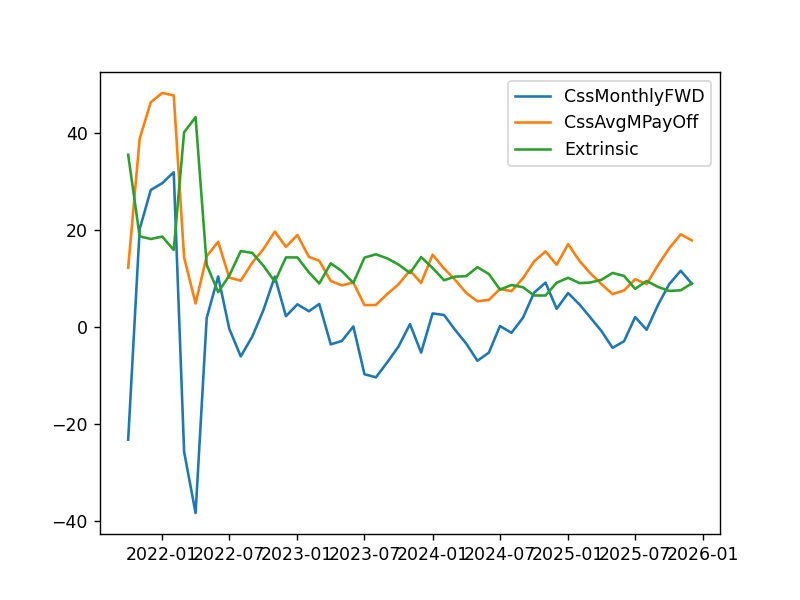

In [405]:
import matplotlib.pyplot as plt

%matplotlib notebook

plt.figure()
plt.plot(CssMonthlyFWD)
plt.plot(CssAvgMPayOff)
plt.plot(df['Extrinsic'])
plt.legend(['CssMonthlyFWD','CssAvgMPayOff','Extrinsic'])

In [409]:
import pandas as pd
import glob
import os
import numpy as np
import datetime as datetime

def cleanSparkSpreadOption(date):

    def listPatternFiles(searchDir, pattern):
        files = glob.glob(os.path.join(searchDir, pattern), recursive = True)
        return files

    #Read the hourly power data:

    today = pd.to_datetime(date)
    tYear = today.year
    tMonth = today.month
    tDay = today.day

    pattern = 'Daily_'+str(tYear)+str(tMonth)+str(tDay)+'*HourlyReleveld.csv'
    searchDir = 'I:/BU Portfolio Analytics/Market Analysis/Power/Models & Tools/Merit Order/PDP/Summary Outputs/'

    HourlyData = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

    #Process the format of daily power data and grabbing as of today-dates only:

    HourlyData['VALUEDATETIME'] = pd.to_datetime(HourlyData['VALUEDATETIME'])
    HourlyData = HourlyData[HourlyData['VALUEDATETIME'] >= pd.Timestamp(today)]
    HourlyData['day'] = [str(i.year) + '-' + str(i.month) + '-' + str(i.day) for i in HourlyData['VALUEDATETIME']]

    #Read gas and carbon daily data:

    pattern = 'Daily_'+str(tYear)+str(tMonth)+str(tDay)+'*BASE CASE_Daily.csv'
    gasAndCarbon = pd.read_csv(listPatternFiles(searchDir, pattern)[0], sep = ";")

    #Process the format of gas and carbon data and grabbing as of today-dates only:

    gasAndCarbon['VALUEDATETIME'] = pd.to_datetime(gasAndCarbon['VALUEDATETIME'])
    gasAndCarbon = gasAndCarbon[gasAndCarbon['VALUEDATETIME'] >= pd.Timestamp(today)]

    #Creating separated dataframes for Carbon and gas from the previous dataframe, setting their index and rejoining them to exclude COAL:

    carbonList = ['CARBON_Sim_'+str(i) for i in range(1,501)]
    gasList = ['GAS_Sim_'+str(i) for i in range(1,501)]
    carbonData = gasAndCarbon[carbonList]
    gasData = gasAndCarbon[gasList]
    carbonData.index = gasAndCarbon['VALUEDATETIME']
    gasData.index = gasAndCarbon['VALUEDATETIME']
    gasAndCarbon = gasData.join(carbonData)

    #Joining the dataframes to transform gas and carbon data in hourly granularity data:

    data = pd.merge(left=HourlyData,
                    right=gasAndCarbon,
                    how='left',
                    left_on = 'VALUEDATETIME',
                    right_on='VALUEDATETIME')
    data = data.fillna(method='ffill')

    #Creating three separated dataframes again for power, gas and CO2:

    powerList = ['POWERPRICES_NL_Sim_'+ str(i) for i in range(1,501)]
    carbonData = data[carbonList]
    gasData = data[gasList]
    powerData = data[powerList]
    carbonData.index, gasData.index, powerData.index = (data['VALUEDATETIME'] for i in range(1,4))

    #Creating hourly CSS simulations

    CssHourly = pd.DataFrame(powerData.values - 1.91900818*gasData.values - 0.353084*carbonData.values)

    #Giving name to columns and rows:

    CssHourly.index = powerData.index
    CssHourly.columns = ['CSS_NL_Sim_'+str(i) for i in range(1,501)]

    CssHourlyFWD = CssHourly.T.mean().T
    CssAvgHPayOff = CssHourly.where(CssHourly >0,0).T.mean().T

    #Creating data with Monthly frequency for the fwd curve:

    CssMonthlyFWD = pd.DataFrame(CssHourlyFWD)
    CssMonthlyFWD.index = pd.to_datetime(CssMonthlyFWD.index)
    CssMonthlyFWD.columns = ['ForwardCss']
    CssMonthlyFWD['Year&Month'] = [str(i.year)+'-'+str(i.month) for i in CssMonthlyFWD.index]
    CssMonthlyFWD = CssMonthlyFWD.groupby('Year&Month').agg(np.mean)
    CssMonthlyFWD.index = pd.to_datetime(CssMonthlyFWD.index)
    CssMonthlyFWD.sort_index(inplace=True)

    #Creating data with Monthly frequency for the extrinsic value:

    CssAvgMPayOff=pd.DataFrame(CssAvgHPayOff)
    CssAvgMPayOff.index = pd.to_datetime(CssAvgMPayOff.index)
    CssAvgMPayOff.columns = ['OptionCss']
    CssAvgMPayOff['Year&Month'] = [str(i.year)+'-'+str(i.month) for i in CssAvgMPayOff.index]
    CssAvgMPayOff = CssAvgMPayOff.groupby('Year&Month').agg(np.mean)
    CssAvgMPayOff.index = pd.to_datetime(CssAvgMPayOff.index)
    CssAvgMPayOff.sort_index(inplace=True)

    #Creating DataFrame with option value, fwd and extrinsic:

    df = pd.DataFrame({'Forward': pd.Series(CssMonthlyFWD['ForwardCss']),
                 'Option_value':pd.Series(CssAvgMPayOff['OptionCss']),
                 'Extrinsic':pd.Series(CssAvgMPayOff['OptionCss']-CssMonthlyFWD['ForwardCss'])})

    #Save it as a csv:

    df.to_csv('C:/Users/D110148/OneDrive - pzem/data/CssExtrinsic'+str(tYear)+str(tMonth)+str(tDay)+'.csv')
    
    return df

In [ ]:
cleanSparkSpreadOption('2021-10-20')

Timestamp('2015-02-15 00:00:00')